In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

data_set_col = "data_set"
threshold = 0.02875984678242102 # full model

model_dir = 'PATH'
data_location = 'PATH/df_with_predictions.feather'
plot_save_location = 'PATH'
n_boot_iters = 20_000

In [2]:
%run ./pe_manuscript_fig5a_helper.py

In [3]:
# Set plot parameters
plt.rcParams["font.size"] = 10
plt.rcParams['lines.markersize'] = 7
plt.rcParams['figure.facecolor'] = (1,1,1,0)
plt.rcParams['axes.facecolor']= (1,1,1,1)

In [4]:
df = pd.read_feather(data_location)

In [5]:
# Filter out MRF samples and failing samples
df = df.loc[(df.pass_all_cv == True) & (df.is_nmrf == True)].reset_index(drop = True).copy()

In [6]:
df["train"] = df[data_set_col] == "train"
df["test"] = df[data_set_col] == "test"

# NMRF AMA ROC 

In [7]:
# LR+ for NMRF AMA
tn, fp, fn, tp = confusion_matrix(df.loc[(df['test'] == True) & (df.is_age_gte35 == True), 'is_green_triangle'].astype(int), df.loc[(df['test'] == True) & (df.is_age_gte35 == True), 'pe_pred_class_full'].astype(int)).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp + fn)
pos_lr = sensitivity / (1 - specificity)
print(f"tn={tn}, fp={fp}, fn={fn}, tp={tp}, specificity={specificity}, sensitivity={sensitivity}, pos_lr={pos_lr}")

tn=290, fp=102, fn=1, tp=10, specificity=0.7397959183673469, sensitivity=0.9090909090909091, pos_lr=3.4937611408199643


In [8]:
# LR+ for NMRF AMA using USPSTF
df['is_pred_uspstf'] = df['uspstf_risk_level'].isin(["high_pe_risk_1high", "high_pe_risk_2mod"])
tn, fp, fn, tp = confusion_matrix(df.loc[(df['test'] == True) & (df.is_age_gte35 == True), 'is_green_triangle'].astype(int), df.loc[(df['test'] == True) & (df.is_age_gte35 == True), 'is_pred_uspstf'].astype(int)).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp + fn)
pos_lr = sensitivity / (1 - specificity)
print(f"tn={tn}, fp={fp}, fn={fn}, tp={tp}, specificity={specificity}, sensitivity={sensitivity}, pos_lr={pos_lr}")

tn=87, fp=305, fn=1, tp=10, specificity=0.22193877551020408, sensitivity=0.9090909090909091, pos_lr=1.1684053651266764


In [9]:
# LR+ for NMRF, 18+
tn, fp, fn, tp = confusion_matrix(df.loc[(df['test'] == True), 'is_green_triangle'].astype(int), df.loc[(df['test'] == True), 'pe_pred_class_full'].astype(int)).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp + fn)
pos_lr = sensitivity / (1 - specificity)
print(f"tn={tn}, fp={fp}, fn={fn}, tp={tp}, specificity={specificity}, sensitivity={sensitivity}, pos_lr={pos_lr}")

tn=1643, fp=547, fn=21, tp=32, specificity=0.7502283105022831, sensitivity=0.6037735849056604, pos_lr=2.417301921285916


In [10]:
# LR+ for NMRF, 18+ using USPSTF
df['is_pred_uspstf'] = df['uspstf_risk_level'].isin(["high_pe_risk_1high", "high_pe_risk_2mod"])
tn, fp, fn, tp = confusion_matrix(df.loc[(df['test'] == True), 'is_green_triangle'].astype(int), df.loc[(df['test'] == True), 'is_pred_uspstf'].astype(int)).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp + fn)
pos_lr = sensitivity / (1 - specificity)
print(f"tn={tn}, fp={fp}, fn={fn}, tp={tp}, specificity={specificity}, sensitivity={sensitivity}, pos_lr={pos_lr}")

tn=1204, fp=986, fn=17, tp=36, specificity=0.5497716894977169, sensitivity=0.6792452830188679, pos_lr=1.5086685292204065


# DGA <= 35 weeks, all non-early GT cases reclassified as control

In [11]:
df['preterm_pe_35'] = False
df.loc[(df['is_green_triangle'] == True) & (df['delivery_ga'] <= 35), 'preterm_pe_35'] = True
df['preterm_pe_35'].value_counts()

preterm_pe_35
False    6598
True       47
Name: count, dtype: int64

In [12]:
# LR+ for NMRF, 18+, and del_ga <= 35 
tn, fp, fn, tp = confusion_matrix(df.loc[(df['test'] == True), 'preterm_pe_35'].astype(int), df.loc[(df['test'] == True), 'pe_pred_class_full'].astype(int)).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp + fn)
pos_lr = sensitivity / (1 - specificity)
print(f"tn={tn}, fp={fp}, fn={fn}, tp={tp}, specificity={specificity}, sensitivity={sensitivity}, pos_lr={pos_lr}")

tn=1661, fp=566, fn=3, tp=13, specificity=0.7458464301751235, sensitivity=0.8125, pos_lr=3.1968860424028276


In [14]:
# LR+ for NMRF, 18+, and del_ga <= 35 using USPSTF 
df['is_pred_uspstf'] = df['uspstf_risk_level'].isin(["high_pe_risk_1high", "high_pe_risk_2mod"])
tn, fp, fn, tp = confusion_matrix(df.loc[(df['test'] == True), 'preterm_pe_35'].astype(int), df.loc[(df['test'] == True), 'is_pred_uspstf'].astype(int)).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp + fn)
pos_lr = sensitivity / (1 - specificity)
print(f"tn={tn}, fp={fp}, fn={fn}, tp={tp}, specificity={specificity}, sensitivity={sensitivity}, pos_lr={pos_lr}")

tn=1217, fp=1010, fn=4, tp=12, specificity=0.5464750785810507, sensitivity=0.75, pos_lr=1.6537128712871285


# Combined plot

In [15]:
# Initialize data set for all and AMA samples to put on same plot. Primarily, initialize subgroup columns.
df_gt = df.loc[df['test'] == True][["pe_pred_prob_full", "is_green_triangle", "is_age_gte35", "preterm_pe_35"]].reset_index(drop=True).copy()
df_gt['plot_all'] = True
df_gt['plot_ama'] = df_gt['is_age_gte35']
df_gt['plot_preterm35'] = False

# Map preterm_pe_35 into is_green_triangle for the <= 35 thresholding plot (required for plot_roc_by_model_subset)
# Set subgroup columns such that only 
df_preterm35 = df_gt.copy()
df_preterm35["is_green_triangle"] = df_preterm35["preterm_pe_35"]
df_preterm35['plot_all'] = False
df_preterm35['plot_ama'] = False
df_preterm35['plot_preterm35'] = True

# Combine
df_combined = pd.concat([df_gt, df_preterm35], axis = 0).reset_index(drop = True).copy()

/mnt/notebook/pe_manuscript_fig5a_helper.py:150: RuntimeWarning: divide by zero encountered in scalar divide
  "DOR": lr_plus / lr_minus,
/mnt/notebook/pe_manuscript_fig5a_helper.py:150: RuntimeWarning: divide by zero encountered in scalar divide
  "DOR": lr_plus / lr_minus,
/mnt/notebook/pe_manuscript_fig5a_helper.py:150: RuntimeWarning: divide by zero encountered in scalar divide
  "DOR": lr_plus / lr_minus,
/mnt/notebook/pe_manuscript_fig5a_helper.py:150: RuntimeWarning: divide by zero encountered in scalar divide
  "DOR": lr_plus / lr_minus,
/mnt/notebook/pe_manuscript_fig5a_helper.py:150: RuntimeWarning: divide by zero encountered in scalar divide
  "DOR": lr_plus / lr_minus,
/mnt/notebook/pe_manuscript_fig5a_helper.py:150: RuntimeWarning: divide by zero encountered in scalar divide
  "DOR": lr_plus / lr_minus,
/mnt/notebook/pe_manuscript_fig5a_helper.py:150: RuntimeWarning: divide by zero encountered in scalar divide
  "DOR": lr_plus / lr_minus,
/mnt/notebook/pe_manuscript_fig5a_


Full, Plot_All
AUC 0.743396 [95% CI: 0.671404 - 0.812090]
No. cases 53
No. controls 2190
Prevalence 2.362907%
Sensitivity 0.603774 [95% CI: 0.466667 - 0.733333]
Specificity 0.750228 [95% CI: 0.731752 - 0.768037]

Full, Plot_Preterm35
AUC 0.829900 [95% CI: 0.684551 - 0.946400]
No. cases 16
No. controls 2227
Prevalence 0.713330%
Sensitivity 0.812500 [95% CI: 0.588235 - 1.000000]
Specificity 0.745846 [95% CI: 0.727394 - 0.763596]

Full, Plot_Ama
AUC 0.881957 [95% CI: 0.758544 - 0.962525]
No. cases 11
No. controls 392
Prevalence 2.729529%
Sensitivity 0.909091 [95% CI: 0.700000 - 1.000000]
Specificity 0.739796 [95% CI: 0.696429 - 0.782828]


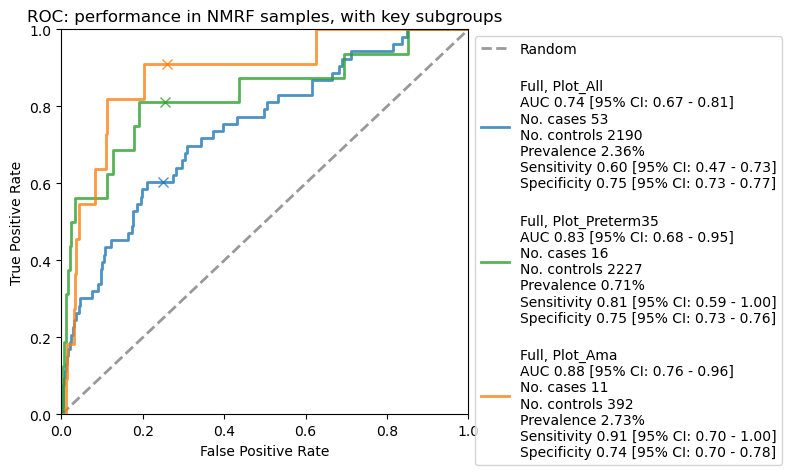

In [ ]:
cm = plt.get_cmap('tab10')
cm_colors = [cm.colors[i] for i in range(3)]
plot_roc_by_model_subset(
    model_outputs=pd.DataFrame(
        {'y_true': df_combined['is_green_triangle'],
        'y_prob_full': df_combined['pe_pred_prob_full']}
    ),
    prob_thresholds={'full': threshold},
    subgroup_filters= df_combined[['plot_all', 'plot_preterm35', 'plot_ama']],
    n_boot_iters = 20000,
    color_dict = {'plot_all': cm_colors[0],
                 'plot_preterm35': cm_colors[2],
                 'plot_ama': cm_colors[1]},
    linestyles ={'full': '-'},
    mark_sensitivity_thres=None,
    mark_specificity_thres=None,
    sens_spec_thresholds = None,
    title = "ROC: performance in NMRF samples, with key subgroups"
)
#plt.savefig(plot_save_location + "roc_nmrf_combined_all_preterm35_ama.svg", format="svg", bbox_inches = "tight")
#plt.savefig(plot_save_location + "roc_nmrf_combined_all_preterm35_ama.pdf", format="pdf", bbox_inches = "tight")
plt.show()